In [1]:
import sys
sys.path.append('../code')
from init_mooc_nb import *
init_notebook()
import scipy.sparse.linalg as sl

my = 0.5 * (pauli.sys0 + pauli.sysz)
s0s0sz = np.kron(pauli.s0s0, pauli.sz)
s0szsz = np.kron(pauli.s0sz, pauli.sz)
mysz = np.kron(my, pauli.s0)
s0s0sx = np.kron(pauli.s0s0, pauli.sx)
s0s0sy = np.kron(pauli.s0s0, pauli.sy)
szsxsz = np.kron(pauli.szsx, pauli.sz)
s0sysz = np.kron(pauli.s0sy, pauli.sz)
sxsxsz = np.kron(pauli.sxsx, pauli.sz)
sysxsz = np.kron(pauli.sysx, pauli.sz)


def make_qshe_sc(l=40, w=10, lead=False):
    def shape(pos):
        (x, y) = pos
        return (1.0 * y**2 / l**2 + 1.0 * x**2 / w**2) <= 0.25

    def onsite(site, p):
        (x, y) = site.pos
        return (p.M - 4 * p.B) * s0szsz - 4 * p.D * s0s0sz + p.gaps(x, y)[1] * mysz + p.gaps(x, y)[0] * s0s0sx

    def hopx(site1, site2, p):
        return p.B * s0szsz + p.D * s0s0sz + 0.5j * p.A * szsxsz

    def hopy(site1, site2, p):
        return p.B * s0szsz + p.D * s0s0sz - 0.5j * p.A * s0sysz

    lat = kwant.lattice.square()
    sys = kwant.Builder()
    sys[lat.shape(shape, (0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy

    if lead:
        sym = kwant.TranslationalSymmetry((0, 1))
        lead = kwant.Builder(sym)
        lead[lat(0, 0)] = 1.5 * p.B * s0szsz
        lead[kwant.HoppingKind((0, 1), lat)] = -p.B * s0szsz
        sys.attach_lead(lead)
        sys.attach_lead(lead.reversed())
    return sys.finalized()


def make_qshe_sc_ribbon(w=3):
    def ribbon_shape(pos):
        (x, y) = pos
        return (0 <= x < w)

    def onsite(site, p):
        (x, y) = site.pos
        return (p.M - 4 * p.B) * s0szsz - 4 * p.D * s0s0sz + p.gaps(x, y)[1] * mysz + p.gaps(x, y)[0] * s0s0sx

    def hopx(site1, site2, p):
        return p.B * s0szsz + p.D * s0s0sz + 0.5j * p.A * szsxsz

    def hopy(site1, site2, p):
        return p.B * s0szsz + p.D * s0s0sz - 0.5j * p.A * s0sysz

    lat = kwant.lattice.square()
    sym = kwant.TranslationalSymmetry((0, 1))
    sys = kwant.Builder(sym)

    sys[lat.shape(ribbon_shape, (0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy

    return sys.finalized()


def make_2d_pwave(w, l):
    def shape(pos):
        (x, y) = pos
        return (1.0 * y**2 / l**2 + 1.0 * x**2 / w**2) <= 0.25

    def hopx(site1, site2, p):
        (x1, y1) = site1.pos
        (x2, y2) = site2.pos
        phi = p.phase(0.5 * (x1 + x2), 0.5 * (y1 + y2))
        return -p.t * pauli.sz + 1j * p.delta * \
            (np.cos(phi) * pauli.sx + np.sin(phi) * pauli.sy)

    def hopy(site1, site2, p):
        (x1, y1) = site1.pos
        (x2, y2) = site2.pos
        phi = p.phase(0.5 * (x1 + x2), 0.5 * (y1 + y2))
        return -p.t * pauli.sz - 1j * p.delta * \
            (np.cos(np.pi / 2 + phi) * pauli.sx +
             np.sin(np.pi / 2 + phi) * pauli.sy)

    def onsite(site1, p):
        return (4 * p.t - p.mu) * pauli.sz

    lat = kwant.lattice.square()
    sys = kwant.Builder()
    sys[lat.shape(shape, (w / 2 - 1, 0))] = onsite
    sys[kwant.HoppingKind((1, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1), lat)] = hopy

    return sys.finalized()


def bhz_slab(l, w, h):
    lat = kwant.lattice.general(np.identity(3))
    sys = kwant.Builder()

    def shape(pos):
        (x, y, z) = pos
        return (0 <= z < h) and (1.0 * y**2 / l**2 + 1.0 * x**2 / w**2) <= 0.25

    def onsite(site, p):
        (x, y, z) = site.pos
        phi = p.phase(x, y)
        return (p.C + 2 * p.D1 + 4 * p.D2) * s0s0sz + (p.M + 2 * p.B1 + 4 * p.B2) * s0szsz + \
            p.delta * (np.cos(phi) * s0s0sx + np.sin(phi) * s0s0sy)

    def hopx(site1, site2, p):
        return - p.D2 * s0s0sz - p.B2 * s0szsz + p.A2 * 0.5j * sxsxsz

    def hopy(site1, site2, p):
        return - p.D2 * s0s0sz - p.B2 * s0szsz + p.A2 * 0.5j * sysxsz

    def hopz(site1, site2, p):
        return - p.D1 * s0s0sz - p.B1 * s0szsz + p.A1 * 0.5j * szsxsz

    sys[lat.shape(shape, (0, 0, 0))] = onsite
    sys[kwant.HoppingKind((1, 0, 0), lat)] = hopx
    sys[kwant.HoppingKind((0, 1, 0), lat)] = hopy
    sys[kwant.HoppingKind((0, 0, 1), lat)] = hopz

    return sys.finalized()


def calc_energies(sys, p, num_orbitals, num_states):
    ham = sys.hamiltonian_submatrix(args=[p], sparse=True).tocsc()
    energies, states = sl.eigsh(ham, sigma=0, k=num_states)
    densities = np.linalg.norm(
        states.reshape(-1, num_orbitals, num_states), axis=1)**2
    return energies, states, densities


Populated the namespace with:
np, matplotlib, kwant, holoviews, init_notebook, interact, display_html, plt, pf, SimpleNamespace, pprint_matrix, scientific_number, pretty_fmt_complex
from code/edx_components:
MoocVideo, PreprintReference, MoocDiscussion, MoocCheckboxesAssessment, MoocMultipleChoiceAssessment, MoocPeerAssessment, MoocSelfAssessment
from code/functions:
spectrum, hamiltonian_array, h_k, pauli


Press this button to show/hide the code used in the notebook:

#Table of Contents
* [Introduction](#Introduction)
* [Different types of bulk-edge correspondence](#Different-types-of-bulk-edge-correspondence)
* [Turning the helical edge into a topological superconductor](#Turning-the-helical-edge-into-a-topological-superconductor)
* [Two-dimensional $p$-wave superconductors](#Two-dimensional-$p$-wave-superconductors)
* [Vortices in 2D p-wave superconductors](#Vortices-in-2D-p-wave-superconductors)
* [Vortices in 3D topological insulator](#Vortices-in-3D-topological-insulator)
* [Conclusions](#Conclusions)


# Introduction

We have a returning lecturer for the first chapter of this week's lectures: Carlo Beenakker from Leiden University, who will tell us more about different ways to create Majoranas in superconducting vortices.

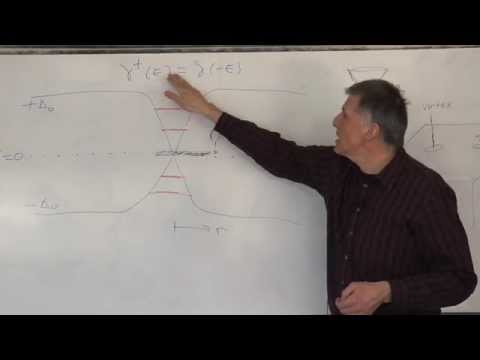

In [2]:
MoocVideo("YVGlfejNH90", src_location="7.1-intro")

# Different types of bulk-edge correspondence

By now, we have seen examples of how the topological properties of the bulk of a material can give birth to new physical properties at its edges, and how these edge properties cannot exist without a bulk. This is the essence of bulk-edge correspondence. For example, the unpaired Majorana bound states at the edges of a Kitaev chain exist because they are separated by the bulk of the chain.

Observe that the systems we have studied so far all had something in common: the topologically protected edge states were separated by a bulk that is one dimension higher than the dimension of the edge states. For example, the 0D Majorana bound states are separated by the 1D bulk of a Kitaev chain, and 1D chiral edge modes are separated by a 2D Chern insulator.

In this week, we will see that this does not need to be the case.

> The dimension of the bulk does not need to be one higher than the dimension of the topologically protected edge. Any dimension higher than the dimension of the edge works equally well.

We will see how this simple insight opens new avenues in the hunt for topological protection.

# Turning the helical edge into a topological superconductor

In the past weeks, we have studied two systems that appear very different, but where topology showed up in a very similar way.

First, let's consider the quantum spin-Hall insulator. As we saw two weeks ago, it is characterized by a fermion parity pump: if you take a Corbino disk made out of a quantum spin-Hall insulator and change the flux by half a normal flux quantum, that is by $h/2e$, one unit of fermion parity is transferred from one edge of the sample to the other.

Secondly, let us consider a one-dimensional topological superconductor, like we studied in weeks two and three. If such a system is closed into a Josephson ring, and the flux through the ring is advanced by one superconducting flux quantum $h/2e$, the fermion parity at the Josephson junction connecting the two ends changes from even to odd, or viceversa. This is the $4π$ Josephson effect, one of the main signatures of topological superconductivity.

Note that the change in flux is equal to $h/2e$ in both cases, since a superconducting flux quantum $h/2e$ is half of the normal flux quantum $h/e$.

This suggest that once you have a quantum-spin Hall insulator, you are only one small step away from topological superconductivity and Majoranas. The only ingredient that is missing is to introduce superconducting pairing on the quantum spin-Hall edge.

But this is easy to add, for instance by putting a superconductor on top of the outer edge of our quantum spin-Hall Corbino disk:

![](figures/qsh_josephson_ring.svg)

The superconductor covers the entire quantum spin-Hall edge except for a small segment, which acts as a Josephson junction with a phase difference given by $\phi = 2e\Phi/\hbar$, where $\Phi$ is the magnetic flux through the center of the disk. We imagine that the superconductor gaps out the helical edge by proximity, which means that Cooper pairs can tunnel in and out from the superconductor into the edge. In order for this to happen, a conventional $s$-wave superconductor is enough.

We will not repeat our pumping experiment, that is increasing the flux $\Phi$ by $h/2e$. We know that one unit of fermion parity must be transferred from the inner edge of the disk to the outer edge. However, the only place where we can now find a zero-energy state is the Josephson junction, because the rest of the edge is gapped.

From the point of view of the superconducting junction, this means that advancing the phase difference $\phi$ by $2\pi$, the ground state fermion parity of the junction changes. Recalling what we learned in the second and third weeks, we can say that the Josephson effect is $4\pi$-periodic.

In [3]:
question = ("What happens to the Josephson current in the setup shown above if you remove the inner edge of the Corbino disk?")

answers = ["The pumping argument fails and the Josephson effect becomes $2\pi$ periodic.",
           "Then you can no longer apply a flux through the disk.",
           "The Josephson effect remains $4\pi$ periodic, but the fermion parity becomes fixed.",
           "Nothing changes if the inner edge of the Corbino disk is removed."]

explanation = ("Josephson current is a local effect, so it cannot be affected by a removal of the inner edge. "
               "When you insert a superconducting flux quantum into the ring, the fermion parity of the edge becomes odd. "
               "The extra fermion comes from the gapped bulk of QSHE, which now acquires one broken "
               "Kramers pair. That is allowed since there is half a normal flux quantum penetrating the bulk, "
               "and Kramers theorem doesn't apply anymore.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=3, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'correct_answer': 3, 'answers': ['The pumping argument fails and the Josephson effect becomes $2\\pi$ periodic.', 'Then you can no longer apply a flux through the disk.', 'The Josephson effect remains $4\\pi$ periodic, but the fermion parity becomes fixed.', 'Nothing changes if the inner edge of the Corbino disk is removed.'], 'max_attempts': 2, 'explanation': "Josephson current is a local effect, so it cannot be affected by a removal of the inner edge. When you insert a superconducting flux quantum into the ring, the fermion parity of the edge becomes odd. The extra fermion comes from the gapped bulk of QSHE, which now acquires one broken Kramers pair. That is allowed since there is half a normal flux quantum penetrating the bulk, and Kramers theorem doesn't apply anymore.", 'question': 'What happens to the Josephson current in the setup shown above if you remove the inner edge of the Corbino disk?'})

## Majoranas on the quantum spin-Hall edge

We know that the $4\pi$-periodicity of the Josephson effect can always be associated with the presence of Majorana zero modes at the two superconducting interfaces of the Josephson junction.

However, if you compare the system above with the Josephson ring studied in week three, you will notice an important difference. In that case, the Josephson junction was formed by an insulating barrier. Now on the other hand, the two superconducting interfaces are connected by the quantum spin-Hall edge.

This means that our Majoranas are connected by a gapless system, and therefore always strongly coupled. In order to see unpaired Majoranas, or at least weakly coupled ones, we need to gap out the segment of the edge forming the Josephson junction.

To gap it out, we can try to place another superconductor in the gap. Unfortunately, this doesn't really help us, because it results in the formation of two Josephson junctions connected in series, and we only want one.

However, we know that the edge modes of the quantum spin-Hall insulator are protected from backscattering by time-reversal symmetry. To gap them out, we need to break time-reversal symmetry. Since a magnetic field breaks time-reversal symmetry, we can gap out the edge modes by placing a magnet on the segment of the edge between the two superconductors:

![](figures/qsh_majoranas.svg)

In the sketch above, you see two Majoranas drawn, one at each interface between the magnet and the superconductor. Their wavefunctions decay as we move away from the interfaces. As Carlo Beenakker mentioned in the introductory video, these Majoranas are quite similar to those we found at the ends of quantum wires.

To understand them in more detail, note that the magnet and the superconductor both introduce a gap in the helical edge, but through a completely different physical mechanism. The magnet flips the spin of an incoming electron, or hole, while the superconductor turns an incoming electron with spin up into an outgoing hole with spin down. These two different types of reflection processes combine together to form a Majorana bound state.

We can capture this behavior with the following Bogoliubov-de Gennes Hamiltonian for the edge:

$$H_\textrm{BdG}=(-iv\sigma_x \partial_x-\mu)\tau_z+m(x)\,\sigma_z+\Delta(x)\,\tau_x.$$

The first term is the edge Hamiltonian of the quantum spin-Hall effect, describing spin up and down electrons moving in opposite direction, together with a chemical potential $\mu$. The matrix $\tau_z$ acts on the particle-hole degrees of freedom, doubling the normal state Hamiltonian as usual. The second term is the Zeeman term due to the presence of the magnet. Finally, the last term is the superconducting pairing.

The strength of the Zeeman field $m(x)$ and the pairing $\Delta(x)$ both depend on position. At a domain wall between the superconductor and the magnet, when the relevant gap for the edge changes between $m$ and $\Delta$, the Hamiltonian above yields a Majorana mode.

This is shown below in a numerical simulation of a quantum spin-Hall disk. The left panel shows the edge state of the disk without any superconductor or magnet. In the right panel we cover one half of the disk by a superconductor and the other by a magnet, and obtain two well-separated Majoranas:

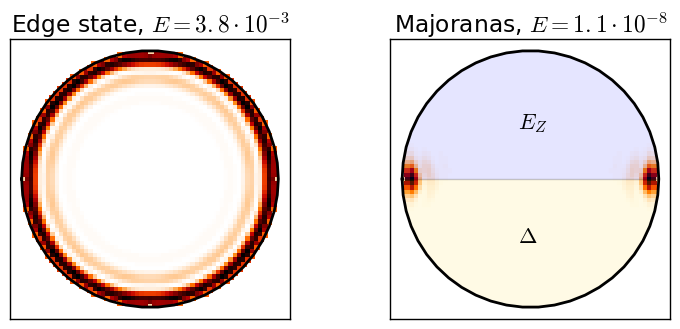

In [4]:
l = 60
w = 60
sys2 = make_qshe_sc(l, w)

p = SimpleNamespace(A=0.5, B=1.00, D=0.1, M=0.5)
p.gaps = lambda x, y: [(y < 0)*0.0, (y >= 0)*0.0]
energies0, states0, densities0 = calc_energies(sys2, p, num_orbitals=8, num_states=10)
p.gaps = lambda x, y: [(y < 0)*0.2, (y >= 0)*0.3]
energies, states, densities = calc_energies(sys2, p, num_orbitals=8, num_states=10)

phi = np.linspace(-np.pi, np.pi, 51)
x = (w + 0.5) / 2 * np.cos(phi)
y = (l + 0.5) / 2 * np.sin(phi)

fig = plt.figure(figsize=(9, 3.5))
ax1 = fig.add_subplot(122)
gap_B = ax1.fill_between(x[:26], 0, y[:26], facecolor='gold', alpha=0.1)
gap_Sc = ax1.fill_between(x[26:], 0, y[26:], facecolor='blue', alpha=0.1)
kwant.plotter.map(sys2, densities[:, 0], colorbar=False, ax=ax1, cmap='gist_heat_r')
plt.plot(x, y, 'k-', lw=2)
text_style = dict(fontsize=16, arrowprops=dict(arrowstyle="-", facecolor='black', lw=0))
plt.annotate('$E_Z$', xytext=(-w/20, l/5), xy=(0, l/3), **text_style)
plt.annotate('$\Delta$', xytext=(-w/20, -l/4), xy=(0, -l/3), **text_style)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_ylim(-l/2-3, l/2+3)
ax1.set_xlim(-w/2-3, w/2+3)
pot = np.log(abs(energies0[0])) // np.log(10.0) - 1
fac = abs(energies0[0])*10**(-pot)
ax1.set_title('Majoranas, $E = $' + scientific_number(abs(energies[0])))

ax0 = fig.add_subplot(121)
kwant.plotter.map(sys2, densities0[:, 0], colorbar=False, ax=ax0, cmap='gist_heat_r')
ax0.set_yticks([])
ax0.set_xticks([])
ax0.set_ylim(-l/2-3, l/2+3)
ax0.set_xlim(-w/2-3, w/2+3)
ax0.set_title('Edge state, $E = $' + scientific_number(abs(energies0[0])))
plt.plot(x, y, 'k-', lw=2)
plt.show()


The density of states plot of the lowest energy state reveals one Majorana mode at each of the two interfaces between the magnet and the superconductor.

This clearly shows how is it possible to obtain 0D topologically protected states (the Majorana modes) from a $2D$ bulk topological phase (the quantum spin Hall insulator). All we had to do was to add the appropriate ingredients (the superconductor and the magnet).

# Two-dimensional $p$-wave superconductors

Let us now move on to Majoranas in vortices, as discussed by Carlo Beenakker in the introductory video. We will need a model for a 2D topological superconductor. How do we obtain it?

It turns out that the method we used to construct 2D Chern insulators in week 4, namely stacking 1D Kitaev chains and coupling them, can also be used to construct 2D topological superconductors.

That isn't very surprising though, is it? Remember that back then, we told you to forget that the Kitaev model was really a superconductor. Bearing that in mind, it comes as no surprise that stacking 1D superconductors gives us a 2D superconductor.

So let's look back at the Hamiltonian we obtained for a Chern insulator by coupling a stack of Kitaev chains: 

$$H_\textrm{2D}(\mathbf{k})=-(2t\cos{k_x}+\mu)\,\tau_z+\Delta\sin{k_x}\tau_y-2\gamma\,(\cos{k_y}\tau_z+\sin{k_y}\,\tau_x).$$ 

Those of us who are careful would want to check that the above Hamiltonian is indeed a superconductor, in particular that the terms coupling different chains do not spoil particle-hole symmetry.

And indeed if we consider the operator $\mathcal{P}=\tau_x \mathcal{K}$ with $\mathcal{K}$ the complex conjugation operator, we find that the Bloch Hamiltonian obeys $H_\textrm{2D}(\mathbf{k}) = -\tau_x H^*_\textrm{2D}(-\mathbf{k}) \tau_x$, precisely the symmetry obeyed by the Kitaev chain, extended to two dimensions (if you do not remember how to apply an anti-unitary symmetry in momentum space, you can go back to week 1 and look at the original derivation).

The Hamiltonian above is quite anisotropic - it looks different in the $x$ and $y$ directions, a consequence of the way we derived it in week four. For our purposes, however, it is convenient to make it look isotropic. Thus, we tweak the coefficients in $H$ to make it look similar in the $x$ and $y$ directions. This is fine as long as we do not close the gap, because the topological properties of $H$ remain unchanged.

In this way we arrive at the canonical Hamiltonian of a so-called $p$-wave superconductor:

$$H(k_x,k_y)=-[2t\,(\cos{k_x}+\cos{k_y})+\mu]\,\tau_z+\Delta\,(\sin{k_x}\tau_y-\sin{k_y}\tau_x).$$

Apart from looking more symmetric between the $x$ and $y$ directions, the Hamiltonian clearly separates normal hopping, which is proportional to $t$, and superconducting pairing, which is proportional to $\Delta$. This superconductor is $p$-wave because the pairing is linear in momentum, just like in the Kitaev chain. This can be seen explicitly by expanding $H$ around $\mathbf{k}=\mathbf{0}$, which gives

$$H(k_x,k_y)\approx [t\,(k_x^2+k_y^2)-\mu+4 t]\tau_z+[i \Delta(k_x+i k_y)\tau_++\textrm{h.c.}],$$

where $\tau_+=(\tau_x+i\tau_y)/2$. Note that the pairing is proportional to $k_x+ik_y$, and it breaks both time-reversal and inversion symmetries.

Even though we have reinterpreted the Hamiltonian $H$ as a superconductor, it is still originally a Chern insulator. This means that the system is still characterized by a bulk Chern number, which determines the presence of chiral edge states.
A chiral edge state can be described by a simple effective Hamiltonian, equivalent to that of a quantum Hall edge:

$$H_\textrm{edge}=\hbar v k$$

with $v$ the velocity and $k$ the momentum along the edge. Note that the edge Hamiltonian maintains the particle-hole symmetry of the bulk: for every state with energy $E$ and momentum $k$ there is a state with energy $-E$ and momentum $-k$.

We are now ready to see how unpaired Majoranas can appear in a 2D $p$-wave superconductor.

# Vortices in 2D p-wave superconductors

So far we have considered a uniform superconducting pairing $\Delta$, with constant amplitude and phase. This is an idealized situation, which corresponds to a perfect superconductor with no defects.

If you apply a small magnetic field to a superconducting film, or if there are defects in the material, a [**vortex**](http://en.wikipedia.org/wiki/Abrikosov_vortex) of supercurrent can form to lower the free energy of the system.
In a vortex, there is a supercurrent circulating in a small area around the defect or the magnetic field lines penetrating the superconductor. The magnetic flux enclosed by the vortex supercurrent is equal to a superconducting flux quantum $h/2e$.

The amplitude $\Delta$ of the superconducting pairing is suppressed in the core of the vortex, going to zero in its center, and the superconducting phase winds by $2\pi$ around a closed path surrounding it. The situation is sketched below:

![](figures/vortex.svg)

Because the pairing $\Delta$ goes to zero in the middle of the vortex, there can be states with an energy smaller than $\Delta$ which are localized at the vortex core. We now want to see whether it is possible to have a non-degenerate zero energy solution in the vortex - because of particle-hole symmetry, this would be an unpaired Majorana mode!

To compute the spectrum of the vortex we could introduce a position dependent-phase for $\Delta$ in the Hamiltonian of the superconductor, and solve it for the energy spectrum by going through quite some algebra. But as usual in this course, we will take a shortcut.

Our shortcut comes from answering the following question: how is the spectrum of the chiral edge states affected by introducing a vortex in the middle of the superconductor?

From week one, we know that changing the flux through a superconducting ring by a flux quantum changes the boundary condition from periodic to antiperiodic, or viceversa.

A vortex has precisely the same effect on the chiral edge states. Therefore, in the presence of a vortex, the allowed values $k_n$ of momentum in a disk shift by $\pi/L$, with $L$ the length of the edge. The energy levels depend linearly on momentum and are shifted accordingly,

$$
E_n\,\to\, E_n + \hbar v \pi / L.
$$

Now, with or without the vortex, the spectrum must be symmetric around $E=0$ because of particle-hole symmetry. The energy levels $E_n$ correspond to standing waves and are equally spaced, with spacing given by $2\hbar v \pi / L$. There are only two such spectra consistent with particle-hole symmetry, $E_n = 2\pi\,n\, \hbar v / L$ and $E_n = 2\pi\,(n+1/2)\, \hbar v / L$.

Which one of the two spectra correspond to the presence of a vortex?

To answer this question, observe that the energy spectrum $E_n = 2 \pi\,n\,\hbar v / L$ includes a zero-energy solution, which is an unpaired Majorana mode at the edge! This is impossible unless there is somewhere a place to have a second zero-energy solution. And the only other possible place where we could have a zero-energy solution is the core of the vortex.

> Just by looking at the edge state momentum quantization, we have thus demonstrated that a vortex in a $p$-wave superconductor must come with a Majorana.

Below, we plot the wave function of the lowest energy state in a $p$-wave disk with a vortex in the middle. The lowest energy wavefunction is an equal superposition of the two Majorana modes. Here you can see that half of it is localized close to the vortex core and half of it close to the edge.

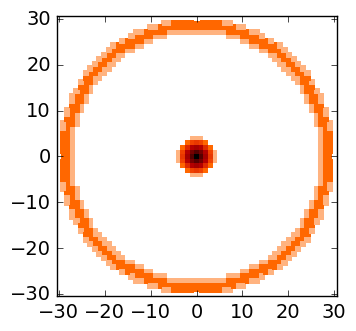

In [5]:
import matplotlib.cm
import matplotlib.colors as mcolors
colors = matplotlib.cm.gist_heat_r(np.linspace(0, 1, 128)**.25)
gist_heat_r_rescaled = mcolors.LinearSegmentedColormap.from_list('gist_heat_r_rescaled', colors)

p = SimpleNamespace(t=1.0, mu=0.4, delta=0.5, phase=lambda x, y: np.angle(x+1j*y))
l = 60
w = 60
sys = make_2d_pwave(w, l)
energies, states, densities = calc_energies(sys, p, num_orbitals=2, num_states=10)
kwant.plotter.map(sys, densities[:, 0], cmap=gist_heat_r_rescaled, show=False, colorbar=False)
plt.show()

The wave function is not zero in the bulk between the edge and the vortex because of the relatively small size of the system. The separation between edge and vortex, or between different vortices, plays the same role as the finite length of a Kitaev chain, i.e. it splits the Majorana modes away from zero energy by an exponentially small amount.

In [6]:
question = ("What happens if you add a second vortex to the superconductor? "
            "Imagine that the vortices and edge are all very far away from each other")

answers = ["The second vortex has no Majorana.",
           "Both vortices have a Majorana, and the edge has two Majoranas.",
           "The Majorana mode at the edge goes away, and each vortex has its own Majorana.",
           "Vortices can only be added in pairs because Majoranas only come in pairs."]

explanation = ("The energy spectrum of the edge is shifted by $\hbar v \pi/L$ by the addition of a second vortex, "
               "so the edge has no Majoranas now. The first vortex is not affected, and we know that it has a Majorana. "
               "And so, of course, the second vortex must have a Majorana as well.")

MoocMultipleChoiceAssessment(question=question, answers=answers, correct_answer=2, explanation=explanation)

MoocMultipleChoiceAssessment(**{'display_name': 'Question', 'correct_answer': 2, 'answers': ['The second vortex has no Majorana.', 'Both vortices have a Majorana, and the edge has two Majoranas.', 'The Majorana mode at the edge goes away, and each vortex has its own Majorana.', 'Vortices can only be added in pairs because Majoranas only come in pairs.'], 'max_attempts': 2, 'explanation': 'The energy spectrum of the edge is shifted by $\\hbar v \\pi/L$ by the addition of a second vortex, so the edge has no Majoranas now. The first vortex is not affected, and we know that it has a Majorana. And so, of course, the second vortex must have a Majorana as well.', 'question': 'What happens if you add a second vortex to the superconductor? Imagine that the vortices and edge are all very far away from each other'})

# Vortices in 3D topological insulator

Unfortunately, superconductors with $p$-wave pairing are very rare, with mainly [one material](http://en.wikipedia.org/wiki/Strontium_ruthenate) being a good candidate. But instead waiting for nature to help us, we can try to be ingenious.

As Carlo mentioned, Fu and Kane [realized](http://arxiv.org/abs/0707.1692) that one could obtain an effective $p$-wave superconductor and Majoranas on the surface of a 3D TI.

We already know how to make Majoranas with a 2D topological insulator. Let us now consider an interface between a magnet and a superconductor on the surface of a 3D topological insulator. Since the surface of the 3D TI is two dimensional, such an interface will be a one dimensional structure and not a point defect as in the quantum spin-Hall case.

The Hamiltonian of the surface is a very simple extension of the edge Hamiltonian,  $\sigma_x k_x + \sigma_y k_y$ instead of just $\sigma_x k_x$. We can imagine that $k_y$ is the momentum along the interface between the magnet and the superconductor, and it is conserved. The effective Bogoliubov-de Gennes Hamiltonian is

$$H_\textrm{BdG}=(-i\sigma_x \partial_x+ \sigma_y k_y-\mu)\tau_z+m(x)\,\sigma_z+\Delta(x) \tau_x.$$

What is the dispersion $E(k_y)$ of states along the interface resulting from this Hamiltonian? Well, for $k_y=0$ we have exactly the Hamiltonian of the magnet/superconductor interface in the quantum spin-Hall case, which had a zero mode. So we know that the interface is gapless. The magnet breaks time-reversal symmetry, so we will have a chiral edge state, with energy $E$ proportional to $k_y$. Just like in the $p$-wave superconductor case!

At this point, analyzing the case of a vortex is very simple. We just have to reproduce the geometry we analyzed before. That is, we imagine an $s$-wave superconductor disk with a vortex in the middle, surrounded by a magnetic insulator, all on the surface of a 3D topological insulator:

![](figures/3d_ti_vortex.svg)

The introduction of a vortex changes the boundary conditions for the momentum at the edge, like in the $p$-wave case, and thus affects the spectrum of the chiral edge states going around the disk.

>Following the same argument as in the $p$-wave case, particle-hole symmetry dictates that there is a Majorana mode in the vortex core on a 3D TI. Interestingly, the vortex core is spatially separated from the magnet - so the vortex should contain a Majorana mode irrespective of the magnet that was used to create the chiral edge mode.

In fact, the magnet was only a crutch that we used to make our argument. We can now throw it away and consider a vortex in a superconductor which covers the entire surface of the topological insulator.

To confirm this conclusion, below we show the result of a simulation of a 3D BHZ model in a cube geometry, with a vortex line passing through the middle of the cube. To make things simple, we have added superconductivity everywhere in the cube, and not just on the surface (nothing prevents us from doing this, even though in real life materials like Bi$_2$Te$_3$ are not naturally superconducting).

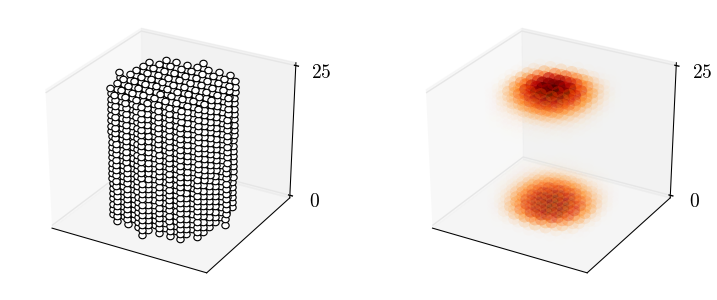

In [7]:
import matplotlib.cm
import matplotlib.colors as mcolors
colors = matplotlib.cm.gist_heat_r(np.linspace(0, 1, 128))
colors[:, 3] = np.linspace(0, 1, 128)
gist_heat_r_transparent = mcolors.LinearSegmentedColormap.from_list('gist_heat_r_transparent', colors)
l, w, h = 10, 10, 25
sys = bhz_slab(l, w, h)

p = SimpleNamespace(A1=0.5, A2=0.5, B1=0.5, B2=0.5, C=-0.2, D1=0.1, D2=0.0, M=-0.2,
                    delta=0.15, phase=lambda x, y: np.angle(x + 1j * y))

energies, states, densities = calc_energies(sys, p, num_orbitals=8, num_states=10)

fig = plt.figure(figsize=(9, 3.5))

ax0 = fig.add_subplot(121, projection='3d')
kwant.plot(sys, ax=ax0, site_size=0.3)
ax0.set_xlim(-w/2-2, w/2+2)
ax0.set_ylim(-l/2-2, l/2+2)
ax0.set_yticks([])
ax0.set_xticks([])
ax0.set_zlim3d([0, h])
ax0.set_zticks([0, h])
ax0.set_zticklabels(['$0$', '$%d$' % h])
densities /= np.max(densities, axis=0, keepdims=True)

ax1 = fig.add_subplot(122, projection='3d')
kwant.plotter.plot(sys, site_color=densities[:, 0], ax=ax1,
                   cmap=gist_heat_r_transparent, colorbar=False, site_lw=0)

ax1.set_xlim(-w/2-2, w/2+2)
ax1.set_ylim(-l/2-2, l/2+2)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.set_zlim3d([0, h])
ax1.set_zticks([0, h])
ax1.set_zticklabels(['$0$', '$%d$' % h])
plt.show()

In the right panel, you can see a plot of the wavefunction of the lowest energy state. You see that it is very well localized at the end points of the vortex line passing through the cube. These are precisely the two Majorana modes that Carlo Beenakker explained at the end of his introductory video.

# Conclusions

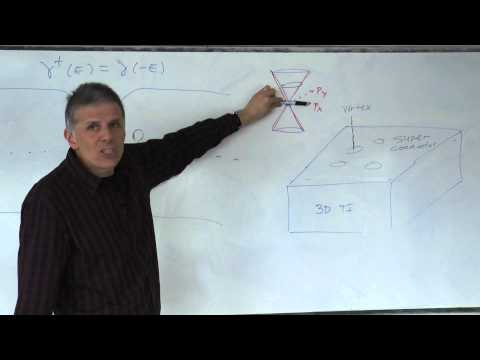

In [8]:
MoocVideo("B7lMz-NrKec", src_location="7.1-summary")

Questions about what you just learned? Ask them below!

In [9]:
MoocDiscussion("Questions", "Majoranas in topological insulators")

MoocDiscussion(**{'discussion_category': 'Questions', 'discussion_id': '243b53c9a4fe3481da813e6be3c13abb', 'display_name': 'Majoranas in topological insulators', 'discussion_target': 'Majoranas in topological insulators'})